# Aula 1 - Criando um gerador

## Vídeo 1.2 - Carregando o fmnist

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Carregar o dataset Fashion MNIST
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar as imagens para o intervalo [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizar para [-1, 1]

# Definir o batch size e preparar o dataset para treinamento
batch_size = 256

# Criar o dataset de treino
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

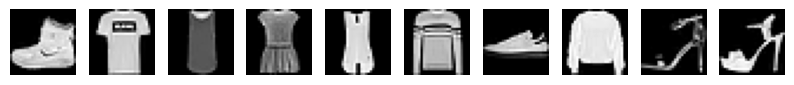

In [5]:
# Exibir algumas imagens de exemplo
num_images_to_show = 10
plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## Vídeo 1.3 - Estruturando um gerador

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
def constroi_gerador():
    modelo = Sequential()

    modelo.add(layers.Input(shape=(100,)))
    modelo.add(layers.Dense(7*7*256, use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Reshape((7, 7, 256)))
    modelo.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return modelo


## Vídeo 1.4 - Gerando uma imagem

In [9]:
# Criação do gerador
gerador = constroi_gerador()

In [10]:
# Gerar Vetor de Ruído
dimensao_ruido = 100
ruido = tf.random.normal([1, dimensao_ruido])

In [11]:
# Gerar imagem a partir do vetor de ruído
imagem_gerada = gerador(ruido, training=False)

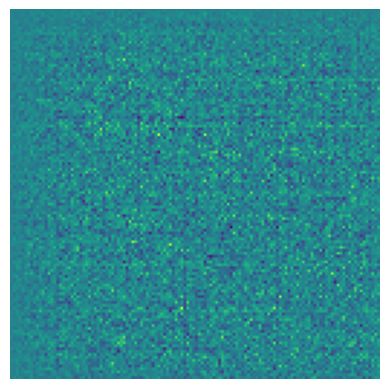

In [16]:
# Visualizar a imagem gerada
import matplotlib.pyplot as plt
plt.imshow((imagem_gerada[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()

# Aula 2 - Implementando um discriminador

## Vídeo 2.1 - Criando a função do discriminador

In [12]:
def constroi_discriminador():
    modelo = Sequential()

    modelo = Sequential()

    modelo.add(layers.Input(shape=(28, 28, 1)))
    modelo.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    modelo.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    # Corrigir a dimensão da Flatten para compatibilizar com a Dense
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1))

    return modelo

In [13]:
discriminador = constroi_discriminador()
decisao = discriminador(imagem_gerada)
print(decisao)

tf.Tensor([[-0.00100413]], shape=(1, 1), dtype=float32)


## Vídeo 2.2 - Definindo as funções de custo

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def custo_discriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def custo_gerador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
otimizador_gerador = tf.keras.optimizers.Adam(1e-4)
otimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

In [19]:
import os

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=otimizador_gerador,
                                 discriminator_optimizer=otimizador_discriminador,
                                 generator=gerador,
                                 discriminator=discriminador)

## Vídeo 2.3 - Definindo um loop de treinamento

In [21]:
epocas = 50
dimensao_ruido = 100
numero_exemplos_treinamento = 16

#Vetor de ruido para gerar imagens
seed = tf.random.normal([numero_exemplos_treinamento, dimensao_ruido])

In [22]:
@tf.function
def passo_treino(images):
    ruido = tf.random.normal([batch_size, dimensao_ruido])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gerador(ruido, training=True)

        real_output = discriminador(images, training=True)
        fake_output = discriminador(generated_images, training=True)

        gen_loss = custo_gerador(fake_output)
        disc_loss = custo_discriminador(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    otimizador_gerador.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    otimizador_discriminador.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))

In [23]:
import time
from IPython.display import clear_output

In [24]:
def treino(dataset, epocas):
    for epoca in range(epocas):
        start = time.time()

        for image_batch in dataset:
           passo_treino(image_batch)

        # Produz as imagens para gerar um gif
        clear_output(wait=True)
        gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)

        # Salva o modelo a cada 15 épocas
        if (epoca + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Tempo por época {} é {} s'.format(epoca + 1, time.time()-start))

    # Gera após a época final
    clear_output(wait=True)
    gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)

In [25]:
def gera_e_salva_imagens(modelo, epoca, entrada):
  # Observe que `training` está definido como False.
  # Isso é para que todas as camadas sejam executadas no modo de inferência (batchnorm).
  previsao = modelo(entrada, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(previsao.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
  plt.show()

## Vídeo 2.4 - Aplicando o treinamento

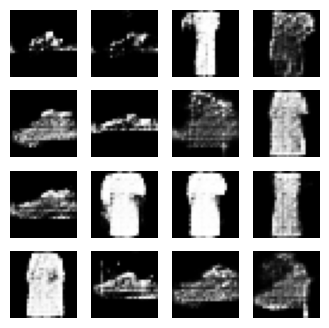

In [29]:
treino(train_ds, epocas)

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [38]:
gerador.save('modelo_gerador.keras')

In [39]:
from tensorflow.keras.models import load_model

gerador_carregado = load_model('modelo_gerador.keras')

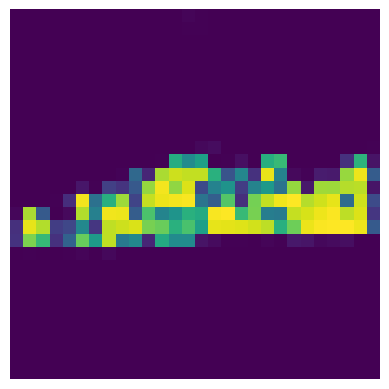

In [42]:
# Gerar um novo vetor de ruído
new_noise = tf.random.normal([1, dimensao_ruido])

# Gerar uma nova imagem usando o modelo carregado
new_generated_image = gerador_carregado(new_noise, training=False)

# Visualizar a nova imagem gerada
plt.imshow((new_generated_image[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()
